# Load Dataset from ~/data

>  Import libraries


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from random import randint
from skimage.transform import resize
from skimage import io, img_as_float
import seaborn as sns


> Utility Section

In [2]:
# Funzione di utility per convertire immagini in vettori
def img2vec(name: str, size: int) -> np.ndarray:
    """Convert images to vector of size (size, size, 3)

    Args:
        name (str): Name of the image as full path
        size (int): Desired size of the image

    Returns:
        np.ndarray: Vector of size (size, size, 3) of numpy.ndarray
    """
    # open image
    img = img_as_float(io.imread(name))
    # convert image to numpy array and resize it
    return resize(img, (size, size, 3))


# Funzione di utility per convertire un vettore in immagine
def vec2img(img_vect: list) -> Image:
    """convert image vector to image"""
    img = Image.fromarray((img_vect * 255.999).astype(np.uint8))
    return img


# Funzione di utility per convertire tutte le immagini in una matrice
def img2matrix(folder: str, size: int) -> np.ndarray:
    """Loop through all images in a folder and convert them into a numpy ndarray.
    Then append every vector to make a matrix of arrays."""
    files = os.listdir(folder)
    counts = len(files)
    img_vect = np.zeros((counts, size, size, 3), dtype=np.float64)
    for i, _ in zip(range(counts), files):
        # convert image to vector
        npArray = img2vec(os.path.join(folder, _), size)
        # append image vector to the empty vector
        img_vect[i, ...] = npArray
    return img_vect


def flat(matrix_list: list) -> list:
    """flatten a list of a matrix n x m x 3 to a list of n x m x 3"""
    shape = np.shape(matrix_list)
    flatted_list = np.asarray(
        [np.reshape(entry, (shape[1] * shape[2] * shape[3])) for entry in matrix_list]
    )
    return flatted_list


> Define source directories

In [3]:
root = "../data"
labels = os.listdir(root)[:2]
datapath = []
for label in labels:
    datapath.append(os.path.join(root, label))
datapath

['../data/Uninfected', '../data/Parasitized']

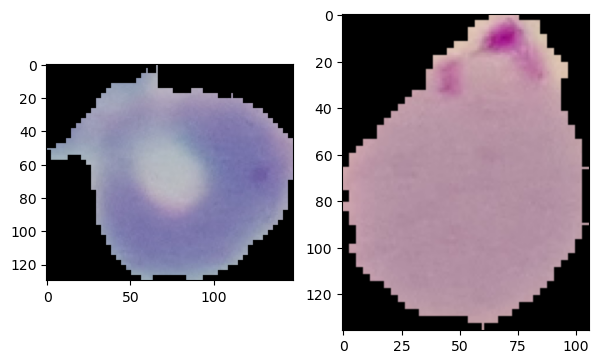

In [13]:
# Display two random images from each class
_, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(Image.open(datapath[0] + "/" + os.listdir(datapath[0])[randint(0, 100)]))
ax[1].imshow(Image.open(datapath[1] + "/" + os.listdir(datapath[1])[randint(0, 100)]))

> Create data structures that will hold the images and their labels

We have 2 classes of images: Uninfected and Parasitized. We will use the following labels for them:
- 0 for Uninfected
- 1 for Parasitized

When we load the images, we will use utility functions to resize them to a common 32x32 pixels in order to reduce the size of the dataset. When flattening the images, we will have 32x32x3 = 3072 features.

*PS: looking at the images, we could see that they are not all the same size. The resizing will help us to have a consistent size for all images. This is a pre-processing step that we will do before training the model.*

In [4]:
# convert images to numpy matrices of size (32, 32, 3)
uninf_imgs = img2matrix(datapath[0], 32)
para_imgs = img2matrix(datapath[1], 32)


In [5]:
# create matrix of features from the numpy vectors
X = np.concatenate((uninf_imgs, para_imgs), axis=0)
# create matrix of labels from the numpy vectors length
y = np.asarray([0] * len(uninf_imgs) + [1] * len(para_imgs))


Is the dataset balanced?  Yes


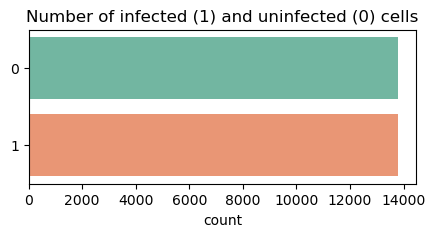

In [6]:
# Count the number of uninfected and infected cells
plt.figure(figsize=(5, 2), dpi=100)
plt.title("Number of infected (1) and uninfected (0) cells")
sns.countplot(y=y, palette="Set2")
print("Is the dataset balanced? ", "Yes" if len(uninf_imgs) == len(para_imgs) else "No")

>Display sample images

We want to see some images to get a feel for the data and to make sure that the data is loaded correctly. We also want to see if there is something detectable by simply looking at the images before we start training a model.

*Using images as dataset means that we have one variable per pixel, and each image is a point in a very high-dimensional space. Single variable distributions and pairwise correlations are completely meaningless and unmanageable.*

In [7]:
# select 10 random integers - we will use them to select images along this initial process
uninf_index = [randint(0, len(os.listdir(datapath[0]))) for _ in range(10)]
para_index = [randint(0, len(os.listdir(datapath[1]))) for _ in range(10)]


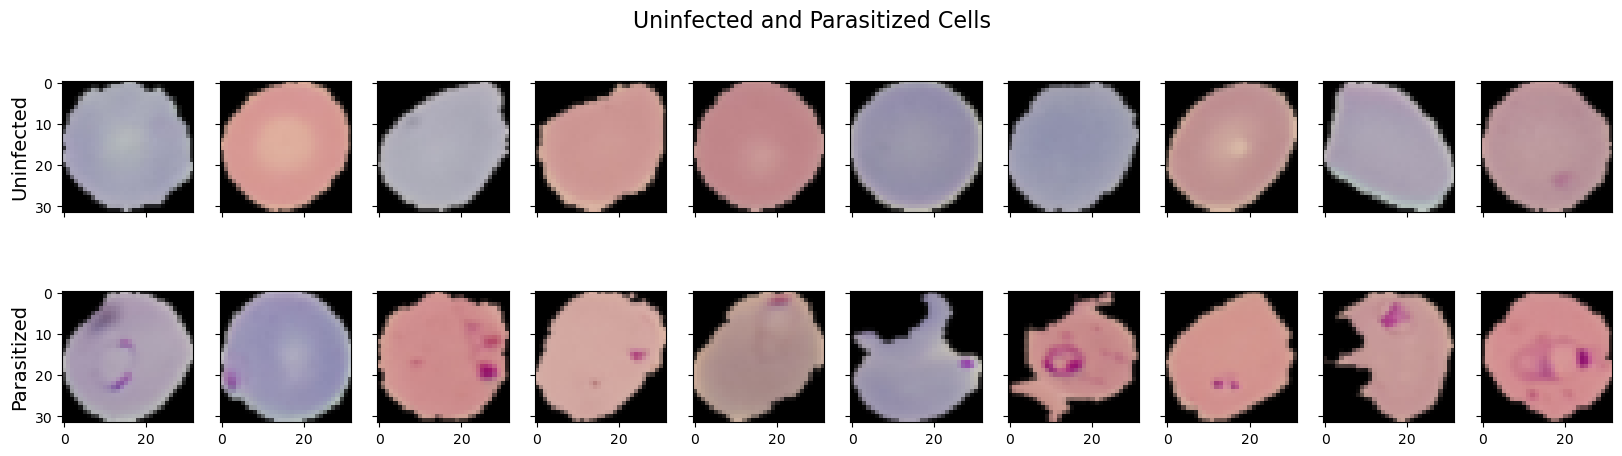

In [8]:
# plot the images
fig, ax = plt.subplots(2, 10, figsize=(20, 5), sharey=True, sharex=True)
fig.suptitle("Uninfected and Parasitized Cells", fontsize=16)
for i in range(10):
    ax[0, i].imshow(uninf_imgs[uninf_index[i]])
    ax[1, i].imshow(para_imgs[para_index[i]])
ax[0, 0].set_ylabel("Uninfected", fontsize=14)
ax[1, 0].set_ylabel("Parasitized", fontsize=14)
plt.show()

Inspecting the images we can see that theese cells are of different shapes and sizes and that the infected cells have some visible violet spots. Theese spots probably will be the most important features for the model to detect.

*If we look more closely, we can see that some images could not be labeled correctly because the violet spots are not visible or some uninfected cells have an intense violet color. This could be a problem for the model and we will have to deal with it later.*

> Simple Image Classification with SKLearn

We will try to classify the images using as input the raw pixels, with a bit of preprocessing such as normalizations and/or grayscaling.

In [27]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
import optuna

# create a function to train and test the model
def classifier(X, y, model, folds):
    # create a K-fold object
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    # create empty lists to store training and prediction the results
    y_true, y_pred = list(), list()
    # loop over the folds, splitting the data into training and testing sets
    for train_index, test_index in skf.split(X, y):
        # split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # train the model
        model.fit(X_train, y_train)
        # evaluate the model on the test set
        y_hat = model.predict(X_test)
        # store the results
        y_true.append(y_test[0])
        y_pred.append(y_hat[0])
    # evaluate the accuracy of the model -> todo: add metrics
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy: %.7f" % acc)
    print(f"Confusion Matrix: {confusion_matrix(y_true, y_pred)}")


In [22]:
# prepare the vectors for the dataframe
X_flat = flat(X)
y_vert = y.reshape(-1, 1)
# make a dataframe from the matrix of features and labels
df = pd.DataFrame(data=X_flat, columns=range(np.shape(X_flat)[1]))
df_labels = pd.DataFrame(data=y_vert, columns=["labels"])
df = df.merge(df_labels, left_index=True, right_index=True)
df.head()


,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


> Split the dataset into Training, Validation and Test sets

- Training set: 70% of the dataset -> we will use this set to train the model after data augmentation
- Validation set: 20% of the dataset -> we will use this set to validate the model
- Test set: 10% of the dataset -> we will use this set to test the model

In [33]:
# Split the data into training validation and test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
# now make two splits:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_flat, y_vert, test_size=test_ratio, random_state=42, shuffle=True, stratify=y_vert
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=val_ratio / (train_ratio + val_ratio),
    random_state=42,
    shuffle=True,
    stratify=y_train_val,
)


> Perform data augmentation

To improve the model performance, we will perform data augmentation on the training set. We will use the following transformations:
- Rotation
- Zoom
- Horizontal and Vertical Flips
- Width and Height Shifts
- Shear Transformation
- Brightness
- Contrast
- Gaussian Noise
- Gaussian Blur
- Motion Blur
- Median Blur
- Random Crop
- To Gray
- Coarse Dropout
- Invert

In [35]:
# we will use the Keras ImageDataGenerator to augment the data
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

((16534, 1), (5512, 1), (5512, 1))

> [Histograms of Oriented Gradients (HOG)](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)

is a feature extraction technique used in image analysis to identify and recognize objects in an image. The HOG technique describes the local appearance of an image in terms of the distribution of the intensity gradients' orientations.

We will use the HOG technique to extract features from the images and use them as input for the model and see if we can get better results.


In [7]:
def split_plot(
    x: np.ndarray, index: int, label: str, plot: bool
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Split image into RGB channels and plot them"""
    # convert vector into image to be splittable
    r, g, b = Image.Image.split(vec2img(x[index]))
    # treat each channel as a numpy array. No need to multiply values by 255 and cast to uint8
    # because the image is already in uint8 format
    npr = np.asarray(r)
    npg = np.asarray(g)
    npb = np.asarray(b)
    np_img = (npr, npg, npb, x[index])
    if plot:
        [_, ax] = plt.subplots(1, 4, figsize=(5, 5), dpi=100)
        cmaps = ["Reds", "Greens", "Blues"]
        channels = ["Red", "Green", "Blue", "RGB"]
        for _ in range(4):
            ax[_].set_title(f"{label[0]} {channels[_]}")
            if _ < 3:
                ax[_].imshow(np_img[_], cmap=cmaps[_])
            else:
                ax[_].imshow(np_img[_])
            ax[_].axis("off")
    return np_img

Create a function to normalize the images and convert them to numpy arrays.
We want to center the data around the mean and scale it to unit variance. This is done by subtracting the mean and dividing by the standard deviation.

In [37]:
def normalize_by_channel(X: np.ndarray) -> np.ndarray:
    """Center and scale the data to have zero mean and unit variance.
    The result is obtained by subtracting the mean and dividing by the standard deviation.
    We do this for each channel of the image, then we merge the channels back together.
    Args:
        X (np.ndarray): Matrix of features to be normalized

    Returns:
        np.ndarray: Matrix of normalized features
    """
    # initialize the list of normalized images
    norm_imgs = []
    # loop over each row in X
    for entry in X:
        # convert the vector to an image and split it into RGB channels
        r, g, b = Image.Image.split(vec2img(entry))
        # convert the channels to numpy arrays to perform the normalization
        npr = np.asarray(r).astype(np.uint8)
        npg = np.asarray(g).astype(np.uint8)
        npb = np.asarray(b).astype(np.uint8)
        # find the mean and standard deviation of each channel
        r_norm = (npr - np.mean(npr)) / np.std(npr)

> Construct the dataset matrices X and y

> Visualize some data informations

> Extract features from images with PCA analysis

> Define generical wrapper function to be able to change models